# PCA of the base transition

In [1]:
import os
import re
import pandas as pd
import seaborn as sns
from Bio import *
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from pca import pca
from sklearn.preprocessing import StandardScaler

In [2]:
def find_key_gene_db_name(filtered_intergenic, startstopdict, position):
    found = 0
    for key in startstopdict.keys(): 
        array = startstopdict[key]
        if position in array: 
            found = 1
            protein_annotation = filtered_intergenic.loc[key, 'protein annotation']
            db_name = filtered_intergenic.loc[key, 'db name']
    if found == 0: 
        protein_annotation = 'no gene'
        db_name = 'no gene'
    return protein_annotation, db_name

def filter_snippy_df(morphology_reference, morphology_reads, reference_phage, inter_or_intra): 
    myo_snippy_df = snippy_df[(snippy_df.loc[:, 'morphology reference'] == morphology_reference) & (snippy_df.loc[:, 'morphology read'] == morphology_reads)]
    pa10myo_snippy_df = myo_snippy_df[myo_snippy_df.loc[:, 'reference'] == reference_phage]
    pa10myo_snippy_df = pa10myo_snippy_df[pa10myo_snippy_df.loc[:, 'inter or intra'] == inter_or_intra]
    return pa10myo_snippy_df

def filter_intergenic_df(phage): 
    df = gbk_df[gbk_df.loc[:, 'phage'] == phage]
    return df
#filtered_snippy = filter_snippy_df('Myoviridae', 'Myoviridae', 'Pa10', 'inter')

In [3]:
snippy_df = pd.read_csv(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\mutational analysis\final_snippy_analysis'
           + '/' + 'snippy_df.csv')
gbk_df = pd.read_csv(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\mutational analysis\compressed dataframes' + '/' + 
                    "intergenic_information_df.csv")
phenotype_df = pd.read_csv(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\mutational analysis\make phenotypic array' + 
                          '/' + 'binary_scaled_myo_plate_reader_df.csv').set_index('phage').reset_index()

In [4]:
# dictionary = {}
# start_stop_big_array = []
# for ii in range(gbk_df.shape[0]): 
#     start = gbk_df.loc[ii, 'start']
#     stop = gbk_df.loc[ii, 'stop']
#     dictionary[ii] = np.arange(start, stop + 1, 1)
    
# gbk_df.loc[:, 'start stop pos array'] = dictionary.values()


# for phage in snippy_df.loc[:, 'reference'].unique(): 
#     #from this point on, we filter further, on the myos and specifically Pa10. 
#     phage = phage
#     filtered_snippy = filter_snippy_df('Myoviridae', 'Myoviridae', phage, 'inter').reset_index(drop = True)
#     filtered_intergenic = filter_intergenic_df(phage = phage)
#     startstopdict = dict(filtered_intergenic.loc[:, 'start stop pos array'])

#     #here, I merge the dataset with the gene the snp finds itself in
#     for ii in range(filtered_snippy.shape[0]): 
#         position = filtered_snippy.loc[ii, 'POS']
#         protein_annotation, db_name = find_key_gene_db_name(filtered_intergenic, startstopdict, position)
#         filtered_snippy.loc[ii, 'protein annotation'] = protein_annotation
#         filtered_snippy.loc[ii, 'db name'] = db_name

#     filtered_snippy.to_csv(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\mutational analysis\compressed dataframes\filtered_snippy_files' 
#                           + '/' + phage + '.csv')

In [5]:
file_list_snippy_files = os.listdir(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\mutational analysis\compressed dataframes\filtered_snippy_files')
all_filtered_snippy = []
for filtered_snippy_file in file_list_snippy_files: 
    filtered_snippy = pd.read_csv(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\mutational analysis\compressed dataframes\filtered_snippy_files' 
                                 + '/' + filtered_snippy_file)
    filtered_snippy.loc[:, 'phage'] = [filtered_snippy_file[:-4]]*filtered_snippy.shape[0]
    all_filtered_snippy = all_filtered_snippy + [filtered_snippy]
all_snippy = pd.concat(all_filtered_snippy)
single_mutations_df = all_snippy[(all_snippy.loc[:, 'REF'].str.len() == 1) & (all_snippy.loc[:, 'ALT'].str.len() == 1)]

gr_single_mutations_df= single_mutations_df.groupby(['REF', 'ALT', 'phage']).count().loc[:,'CHROM'].rename({'CHROM': 'number of snps'}, axis = 1).reset_index().rename({'CHROM': 'tot number of mutations'}, axis = 1)
#heatmap_df = gr_single_mutations_df.pivot_table(index = ['REF', 'ALT'], columns='phage', values = 'tot number of mutations')
gr_single_mutations_df.loc[:, 'group'] = gr_single_mutations_df.loc[:, 'REF'] + ' to ' + gr_single_mutations_df.loc[:, 'ALT']
heatmap_df = gr_single_mutations_df.pivot_table(index = 'phage', columns = 'group', values = 'tot number of mutations')

Do we see a difference between the amount of conversions when RADAR gives a protection? My hypothesis is that when RADAR affects the phage, the are A to G conversions occuring. 

In [6]:
defence_systems = phenotype_df.set_index('phage').columns

In [7]:
defence_systems = phenotype_df.set_index('phage').columns
dataframe_array = []
for defence_system in defence_systems:
    order = ['A to G', 'G to A', 'T to C', 'C to T']
    ds_snippy_df = pd.merge(single_mutations_df, phenotype_df[['phage',defence_system]])
    gr_ds_snippy_df = ds_snippy_df.groupby(['REF', 'ALT', defence_system], as_index = False).count().sort_values('CHROM', ascending = False)
    gr_ds_snippy_df.loc[:, 'conversion'] = gr_ds_snippy_df.loc[:, 'REF'] + ' to ' + gr_ds_snippy_df.loc[:, 'ALT']
    gr_ds_snippy_df = gr_ds_snippy_df.set_index('conversion').loc[order].reset_index()[['conversion', 'Unnamed: 0',defence_system]]
    gr_ds_snippy_df = gr_ds_snippy_df.rename({defence_system: 'affected'}, axis = 1)
    gr_ds_snippy_df.loc[:, 'defence system'] = [defence_system]*gr_ds_snippy_df.shape[0]
    #display(gr_ds_snippy_df)
    dataframe_array = dataframe_array + [gr_ds_snippy_df]

In [8]:
barplot_data = pd.concat(dataframe_array)
sum_affected = phenotype_df.sum().drop('phage')
sum_unaffected = (phenotype_df == 0).sum().drop('phage')
affected_unaffected_count = pd.concat([sum_affected, sum_unaffected], axis = 1).rename({0: 'affected', 1: 'unaffected'}, axis = 1).reset_index().rename({'index': 'defence system'}, axis=1)
barplot_data = pd.merge(barplot_data, affected_unaffected_count, left_on='defence system', right_on = 'defence system').rename({'affected_y': 'num affected', 'unaffected': 'num unaffected'}, axis = 1)
barplot_data.loc[:, 'num affected unaffected'] = barplot_data.loc[:, 'affected_x']*barplot_data.loc[:, 'num affected']
indexes = barplot_data.loc[:, 'affected_x'] == False
barplot_data.loc[:, 'num affected unaffected'] = barplot_data.loc[:, 'num affected unaffected'] + indexes*barplot_data.loc[:, 'num unaffected']
barplot_data.loc[:, 'normalized count'] = barplot_data.loc[:, 'Unnamed: 0']/barplot_data.loc[:, 'num affected unaffected']

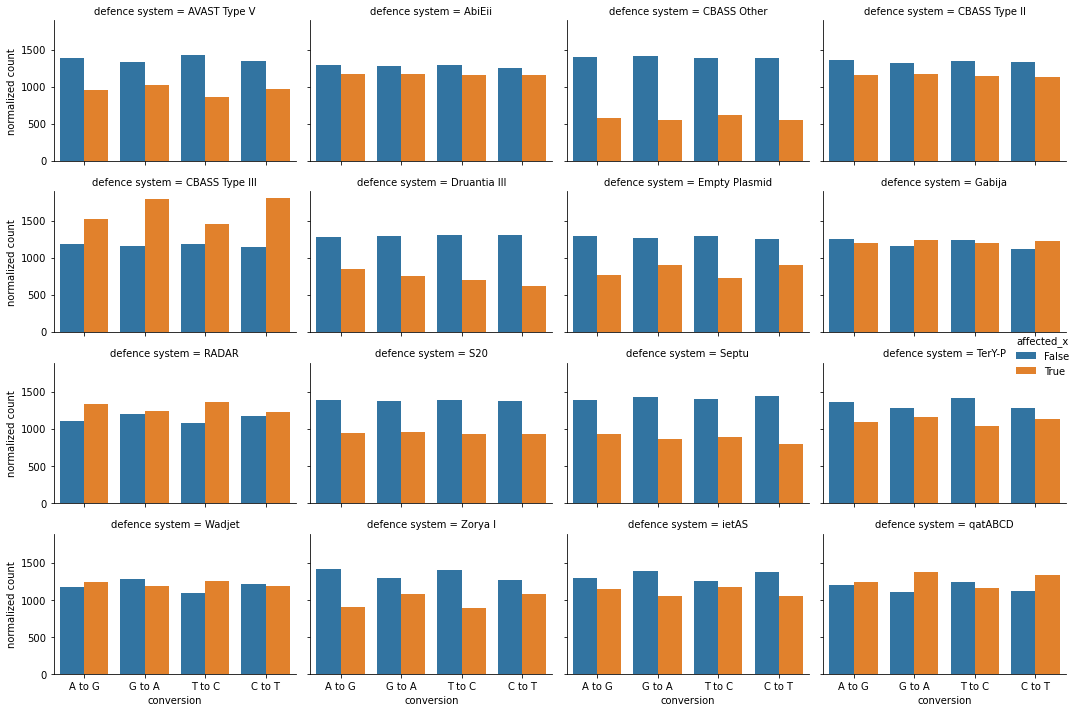

In [9]:
# g = sns.FacetGrid(barplot_data, col = 'defence system', col_wrap=4)
# g.map(catplot, x = 'conversion', y = 'Unnamed: 0')

g = sns.catplot(x="conversion", col="defence system", y = 'normalized count', col_wrap=4, hue='affected_x',
                data=barplot_data,
                kind="bar", height=2.5, aspect=.8, margin_titles=False)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.tight_layout()


How would the clustermap look like?

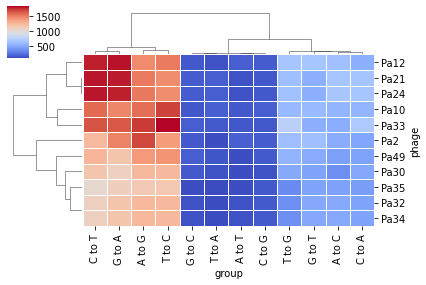

In [10]:
sns.clustermap(heatmap_df, cmap = 'coolwarm', linewidths = 0.7, figsize=(6,4))
plt.show()

How would the PCA look like? 

In [11]:
#do a standar scaler over the rows
scaled_heatmap_df = pd.DataFrame(StandardScaler().fit_transform(heatmap_df.transpose())).transpose()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


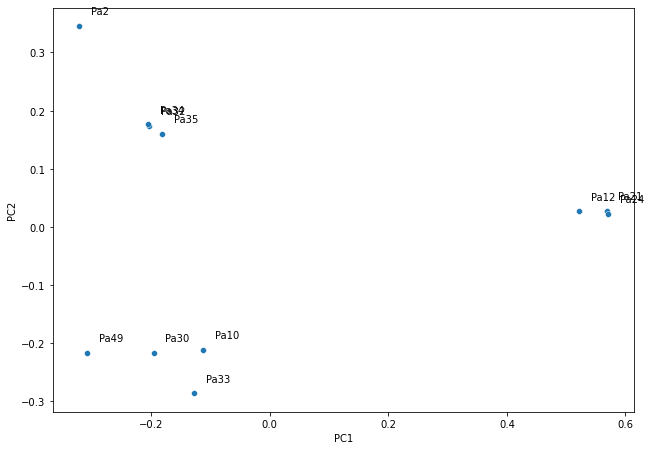

In [12]:
model = pca(n_components = 4, normalize=False)
result = model.fit_transform(scaled_heatmap_df)
scatter_df = result['PC']
explained_var = result['explained_var']

name_df = scatter_df.drop(['PC3', 'PC4'], axis = 1)
name_df.loc[:, 'phage'] = heatmap_df.index
name_df

sns.scatterplot(data = scatter_df, x = 'PC1', y = 'PC2')
fig = plt.gcf()
ax = plt.gca()

delta = 0.02
for ii in range(name_df.shape[0]): 
    x = name_df.loc[ii, 'PC1']
    y = name_df.loc[ii, 'PC2']
    phage_name = name_df.loc[ii, 'phage']
    
    plt.text(x = x + delta, y = y + delta, s = phage_name)
    
plt.tight_layout()
fig.set_size_inches(10, 7)

In [13]:
model = pca(n_components = 4, normalize=False)
result = model.fit_transform(plate_reader_df)
scatter_df = result['PC']
explained_var = result['explained_var']

NameError: name 'plate_reader_df' is not defined

all snippy, specifically A to G

In [ ]:
tot_num_mut = single_mutations_df.groupby('reference', as_index = True).count()[['CHROM']].rename({'CHROM': 'tot number of mutations'}, axis = 1).reset_index()
to_heatmap_df = pd.merge(single_mutations_df.groupby(['REF', 'ALT', 'reference', 'reads'], as_index= True).count()[['CHROM']].rename({'CHROM': 'number of mutations'}, axis = 1).reset_index(), tot_num_mut)
to_heatmap_df.loc[:, 'percentage'] = to_heatmap_df.loc[:, 'number of mutations']/to_heatmap_df.loc[:, 'tot number of mutations']*100
a_to_g_heatmap = to_heatmap_df.drop(['number of mutations', 'tot number of mutations'], axis = 1)
a_to_g_heatmap = a_to_g_heatmap[(a_to_g_heatmap.loc[:, 'REF'] == 'A') & (a_to_g_heatmap.loc[:, 'ALT'] == 'G')]
a_to_g_heatmap = a_to_g_heatmap.pivot_table(columns = 'reference', index = 'reads', values = 'percentage')

In [ ]:
a_to_g_heatmap
sns.clustermap(a_to_g_heatmap.fillna(0),figsize=(5,5), cmap = 'coolwarm', linewidths = 0.5)
plt.show()

In [ ]:
tot_num_mut = single_mutations_df.groupby('reference', as_index = True).count()[['CHROM']].rename({'CHROM': 'tot number of mutations'}, axis = 1).reset_index()
to_heatmap_df = pd.merge(single_mutations_df.groupby(['REF', 'ALT', 'reference', 'reads'], as_index= True).count()[['CHROM']].rename({'CHROM': 'number of mutations'}, axis = 1).reset_index(), tot_num_mut)
to_heatmap_df.loc[:, 'percentage'] = to_heatmap_df.loc[:, 'number of mutations']/to_heatmap_df.loc[:, 'tot number of mutations']*100
g_to_a_heatmap = to_heatmap_df.drop(['number of mutations', 'tot number of mutations'], axis = 1)
g_to_a_heatmap = g_to_a_heatmap[(g_to_a_heatmap.loc[:, 'REF'] == 'G') & (g_to_a_heatmap.loc[:, 'ALT'] == 'A')]
g_to_a_heatmap = g_to_a_heatmap.pivot_table(columns = 'reference', index = 'reads', values = 'percentage')

In [ ]:
sns.clustermap(g_to_a_heatmap.fillna(0),figsize=(5,5), cmap = 'coolwarm', linewidths = 0.5)
plt.show()